# Processing of Amazon Reviews Dataset

## Data Loading and EDA

### Libraries

In [1]:
!pip install num2words
!pip install stop-words

In [2]:
import os
import gzip
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split # Processing
from collections import Counter # Exploration
from nltk import ngrams # Exploration
from nltk.probability import FreqDist # Exploration
from stop_words import get_stop_words # Processing
import unicodedata # Processing
import re # Processing
from num2words import num2words

### Dataset loading

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [4]:
Working_path = '/content/drive/MyDrive/Bootcamp/NLP/Project/Datasets'

In [5]:
%cd $Working_path

/content/drive/MyDrive/Bootcamp/NLP/Project/Datasets


In [6]:
%pwd

'/content/drive/MyDrive/Bootcamp/NLP/Project/Datasets'

In [7]:
df = pd.read_json('reviews_CDs_and_Vinyl_5.json.gz', compression='gzip', lines=True)

In [8]:
df.shape

(1097592, 9)

We are going to be working with a subset of the full data frame to not overload memory.

In [9]:
n_samples = 10000
subset = df.sample(n=n_samples, random_state=42)
subset.shape


(10000, 9)

In [10]:
df_reviews = subset.drop(columns=['reviewerID', 'asin', 'reviewerName', 'helpful', 'unixReviewTime', 'reviewTime'])
df_reviews.dropna(inplace=True)
df_reviews = df_reviews.reset_index(drop=True)

### Exploratory analysis

In [11]:
df_reviews.head(10)

,reviewText,overall,summary
0,Another excellent album! I didn't think she co...,4,Give this woman a chance!
1,Eno's work sounds increasingly like someone ru...,3,The Emperor has more new clothes
2,"This is, to me, possibly Sepultura's most cons...",5,WWoOOOOOOOOOooWW!!!!!!!! Now this was a Surpri...
3,I am really impressed with this CD! Kelly Clar...,5,America Voted Correctly!!!!!!
4,The blues do not get any bluer than this. Thi...,5,The blues do not get any bluer than this.........
5,.. I found this release to be rather &quot;scr...,2,"Loud, very loud"
6,"So, I bought this band's 2009 album Retributio...",4,Very Entertaining and Overall Good Album
7,I disagree that Jack Scott sounded like any ot...,5,Unlike Anyone Else Actually
8,"When I bought it,i didn't like it too much, bu...",5,ENERGY
9,The cd of This is Where I came in is a really ...,4,BEE GEES


It looks like the real review is in reviewText but summary also has some information for the overall sentiment. We will keep both for now.
Maybe we could combine them into one only column

In [12]:
# For now, I am going to drop 'summary' and work the difference with it later
df_reviews.drop(columns=['summary'], inplace=True)

### Overall sentiment distribution (reviews)

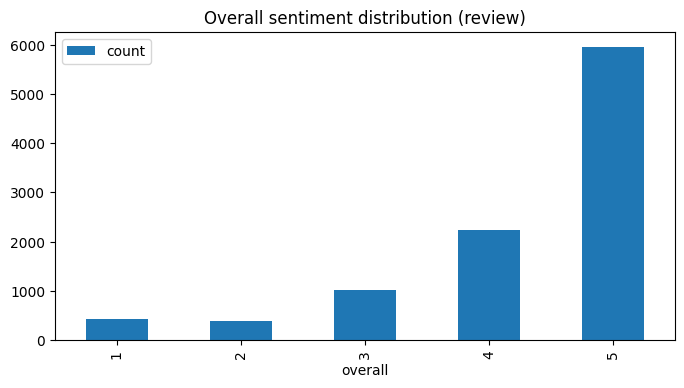

In [13]:
df_sentiment = pd.DataFrame(df_reviews['overall'].value_counts(sort=False).sort_index())
df_sentiment = df_sentiment.plot(kind='bar', title='Overall sentiment distribution (review)', figsize=(8, 4))

The majority of sentiments from the reviews are pretty high, concentrating in 4 and 5 values.
I'm going to consider that anything below 4, it's a bad review and label the sentiment ina binary variable accordingly.

In [14]:
def label_sentiment(row):
    if int(row['overall']) < 4:
        return 1 # considering 1 as negative reviews.
    else:
        return 0 # as positive reviews

In [15]:
# Create 'sentiment_label' column
df_reviews['sentiment_label'] = df_reviews.apply(lambda row: label_sentiment(row), axis=1)
df_reviews.head()

,reviewText,overall,sentiment_label
0,Another excellent album! I didn't think she co...,4,0
1,Eno's work sounds increasingly like someone ru...,3,1
2,"This is, to me, possibly Sepultura's most cons...",5,0
3,I am really impressed with this CD! Kelly Clar...,5,0
4,The blues do not get any bluer than this. Thi...,5,0



Review Counts:
Positive reviews (0): 8196
Negative reviews (1): 1804

Total reviews: 10000


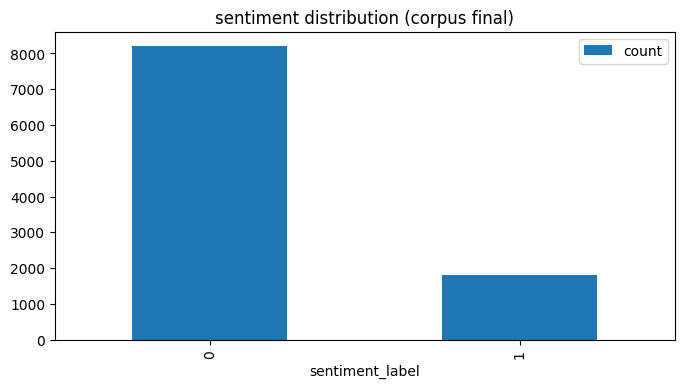

In [16]:
# plot the number of positive and negative reviews
df_sentiment = pd.DataFrame(df_reviews['sentiment_label'].value_counts(sort=False).sort_index())
df_sentiment = df_sentiment.plot(kind='bar', title='sentiment distribution (corpus final)', figsize=(8, 4))

counts = df_reviews['sentiment_label'].value_counts().sort_index()

print("\nReview Counts:")
print(f"Positive reviews (0): {counts[0]}")
print(f"Negative reviews (1): {counts[1]}")
print(f"\nTotal reviews: {len(df_reviews)}")

### Data split into train and test subsets

In order to avoid data leakeage during the exploratory analysis, I am going to divide the dataset into train and test subsets and continue working only on train subset.

In [17]:
# Divide subset into train and test (ej. 80% train, 20% test)
X = df_reviews["reviewText"]
y = df_reviews["sentiment_label"]

X_train_orig, X_test, y_train_orig, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Mostramos resumen
def resumen_split(y_train, y_test):
    print("\n TRAIN SET:")
    print(y_train_orig.value_counts())
    print((y_train_orig.value_counts(normalize=True)*100).round(2).astype(str) + '%')

    print("\n TEST SET:")
    print(y_test.value_counts())
    print((y_test.value_counts(normalize=True)*100).round(2).astype(str) + '%')

resumen_split(y_train_orig, y_test)


 TRAIN SET:
sentiment_label
0    6557
1    1443
Name: count, dtype: int64
sentiment_label
0    81.96%
1    18.04%
Name: proportion, dtype: object

 TEST SET:
sentiment_label
0    1639
1     361
Name: count, dtype: int64
sentiment_label
0    81.95%
1    18.05%
Name: proportion, dtype: object


At this point, after reflecting on the current data distribution, I’m concerned that during training the model may learn to predict positive reviews well, but struggle to accurately predict negative reviews. To address this, I plan to implement a strategy that oversamples the negative review class by adding more examples from the original dataset, while slightly reducing the number of positive reviews. This adjustment will apply only to the training data, ensuring that the validation and test sets continue to reflect the real-world distribution.

### Building train and test subsets



In [18]:


df_train_orig = pd.DataFrame({"reviewText": X_train_orig, "sentiment_label": y_train_orig})

# Separate positive and negative reviews
df_train_neg = df_train_orig[df_train_orig["sentiment_label"] == 1]
df_train_pos = df_train_orig[df_train_orig["sentiment_label"] == 0]

# Number of negative reviews in train
n_neg = len(df_train_neg)

# Subsample same number of positive reviews as negatives.
df_train_pos_sampled = df_train_pos.sample(n=n_neg, random_state=42)

# Join pos and neg reviews again and suffle
df_train_balanced = pd.concat([df_train_neg, df_train_pos_sampled]).sample(frac=1, random_state=42)

# Final train y test
X_train_bal = df_train_balanced["reviewText"]
y_train_bal = df_train_balanced["sentiment_label"]

counts = df_train_balanced['sentiment_label'].value_counts().sort_index()

print("\nTrain Review Counts:")
print(f"Positive reviews (0): {counts[0]}")
print(f"Negative reviews (1): {counts[1]}")
print(f"\nTotal reviews: {len(df_train_balanced)}")


Train Review Counts:
Positive reviews (0): 1443
Negative reviews (1): 1443

Total reviews: 2886


From now on, I will work ONLY with the (balanced) train subset

In [19]:
df_train_balanced.head()
#df_train_balanced.shape

,reviewText,sentiment_label
6932,The Matches is the kind of band everyone shoul...,1
4596,"In 45 years of listening to Sinatra, I'm convi...",0
3074,"I listen to this disc when I am at home, and e...",0
755,The latest to be released (as of November 2012...,0
4720,George got the better of the deal in this pack...,1


### Vocabulary

In [64]:
# Normalization
# Convert to lowercase and remove leading/trailing whitespace
min_split_reviews = df_train_balanced['reviewText'].str.lower().str.strip()

# Replace digits with their word equivalents
#def format_numbers(sentence):
    #return re.sub(r'\d+', lambda x: num2words(int(x.group())), sentence)

#format_number = min_split_reviews.apply(format_numbers)

# Fix incorrect punctuation spacing (add spaces around dots and other punctuation)
def normalize_spacing(text):
    # Add space around dots not between numbers (like 3.14)
    text = re.sub(r'(?<!\d)\.(?!\d|\s|$)', ' . ', text)
    # Add space around other common punctuation
    text = re.sub(r'([,!?;:])(?!\s|$)', r'\1 ', text)
    # Remove multiple spaces
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

normalized_spacing = min_split_reviews.apply(normalize_spacing)
# Remove special characters (keep words, spaces, and apostrophes)
cleaned_text = normalized_spacing.apply(lambda x: re.sub(r"[^\w\s']", '', x))

# Tokenization by words (split on whitespace and punctuation except apostrophes)
words = cleaned_text.apply(lambda x: re.split(r'[ .]+', x))

# Build vocabulary
vocabulary = Counter([word for review in words for word in review])

In [65]:
print('Reviews original: {}'.format(df_train_balanced['reviewText'].values[0]))
#print('Reviews min and split: {}'.format(min_split_reviews.values[0]))
#print('Reviews normalized spacing: {}'.format(normalized_spacing.values[0]))
#print('Reviews non special chars: {}'.format(cleaned_text.values[0]))
print('Reviews words: {}'.format(words.values[0]))

Reviews original: The Matches is the kind of band everyone should watch, not only do I think they will become a huge sensation in the next few years, I think their material will be looked at closer. This is one of those reviews.The Matches first album, E. Von Dahl Killed The Locals (title comes from the man who made them change their name from The Locals to The Matches), is a modest pop-punk album. It's lyrics are well written and well sung, if not very deep. The album is the self-biography of the band, and mixed in there are the required girlfriend (or lack therefor of) complaints and social this-has-to-be-the-end-of-my-life ideas and dramas of an 18 year old.While a great first time effort, the main problem is that E. Von Dahl lacks any variety or musical depth that other major bands produce. I'd recomend this album to many people, but I can't see this being their best work.
Reviews words: ['the', 'matches', 'is', 'the', 'kind', 'of', 'band', 'everyone', 'should', 'watch', 'not', 'on

In [22]:

len(vocabulary)

32451

### N-grams

In [23]:
bigrams = words.apply(lambda x: list(ngrams(x, 2))).explode().dropna()
bigrams_freq = FreqDist(bigrams.tolist())
trigrams = words.apply(lambda x: list(ngrams(x, 3))).explode().dropna()
trigrams_freq = FreqDist(trigrams.tolist())

In [24]:
bigrams_freq.most_common(10)

[(('of', 'the'), 3291),
 (('in', 'the'), 1553),
 (('is', 'a'), 1448),
 (('this', 'album'), 1439),
 (('this', 'is'), 1227),
 (('on', 'the'), 1204),
 (('and', 'the'), 1073),
 (('to', 'the'), 1069),
 (('one', 'of'), 911),
 (('the', 'album'), 874)]

In [25]:
trigrams_freq.most_common(10)

[(('one', 'of', 'the'), 493),
 (('this', 'is', 'a'), 336),
 (('this', 'album', 'is'), 307),
 (('is', 'one', 'of'), 240),
 (('some', 'of', 'the'), 227),
 (('on', 'this', 'album'), 218),
 (('of', 'the', 'songs'), 207),
 (('a', 'lot', 'of'), 190),
 (('of', 'the', 'album'), 170),
 (('the', 'rest', 'of'), 167)]

Most of the n-grams seem to be combinations of stopwords and numbers.
Some others refer to some characteristic refering to the album in the review: ('this', 'album', 'is'), ('this', 'album'), which look like they could be removed together with the stopwords.

In [26]:
most_common = vocabulary.most_common(25)
most_common

[('the', 26556),
 ('and', 13983),
 ('of', 12692),
 ('a', 12464),
 ('to', 10733),
 ('is', 9649),
 ('this', 8020),
 ('i', 7996),
 ('it', 6458),
 ('in', 6085),
 ('that', 5936),
 ('on', 4699),
 ('album', 4348),
 ('with', 4303),
 ('but', 4109),
 ('for', 3772),
 ('you', 3618),
 ('as', 3612),
 ('are', 3304),
 ('was', 2946),
 ('not', 2849),
 ('like', 2660),
 ('one', 2622),
 ('have', 2484),
 ('songs', 2330)]

When looking at the most common words, it looks like, indeed we might benefit from removing stop-words and others such as 'album' because they appear in most of the reviews.

### WordCloud

In [27]:
STOPWORDS = get_stop_words('en')
STOPWORDS

['a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 "can't",
 'cannot',
 'could',
 "couldn't",
 'did',
 "didn't",
 'do',
 'does',
 "doesn't",
 'doing',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 "hadn't",
 'has',
 "hasn't",
 'have',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 "he's",
 'her',
 'here',
 "here's",
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 "how's",
 'i',
 "i'd",
 "i'll",
 "i'm",
 "i've",
 'if',
 'in',
 'into',
 'is',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 "let's",
 'me',
 'more',
 'most',
 "mustn't",
 'my',
 'myself',
 'no',
 'nor',
 'not',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'ought',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'same',
 "shan't",
 'she',
 "she'd",
 "she'll",
 "she's",
 'should',
 "s

The preliminar list of stopwords, removes too many words that, in my opinion could be key to distinguish positive from negative reviews. So I am going to create a custom list of stopword based on the most common connecting words in the texts.

In [28]:
words_to_conserve = {
    'are', "aren't", 'be', "can't", 'cannot', 'could', "couldn't",
    'did', "didn't", 'do', 'does', "doesn't", 'doing', "don't",
    'had', "hadn't", 'has', "hasn't", 'have', "haven't", 'having',
    "weren't", "won't", 'would', "wouldn't", 'was', "wasn't",
    'no', 'nor', 'not'
}
#topic_words = {'song', 'album', 'sound', 'music', 'cd', 'quot', 'songs'}
stopwords_custom = set(STOPWORDS)- words_to_conserve
stopwords_custom.update(['song', 'album', 'sound', 'music', 'cd', 'quot', 'songs'])

In [29]:
from wordcloud import WordCloud, STOPWORDS
#from nltk.corpus import stopwords

def plot_word_cloud(text, title=None):
    wordcloud = WordCloud(
        max_font_size=50,
        max_words=25,
        background_color="white",
        colormap='viridis',
        stopwords = stopwords_custom
    ).generate(text)
    plt.figure(figsize=(12,6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

In [30]:
positive_text = ' '.join(df_train_balanced[df_train_balanced['sentiment_label'] == 0]['reviewText'].astype(str))
negative_text = ' '.join(df_train_balanced[df_train_balanced['sentiment_label'] == 1]['reviewText'].astype(str))

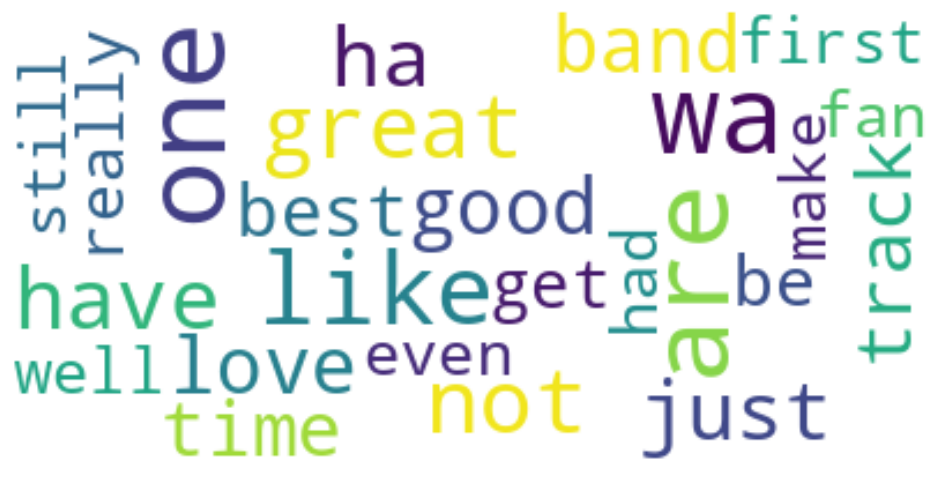

In [31]:
plot_word_cloud(positive_text, title="Positive Sentiment Word Cloud")


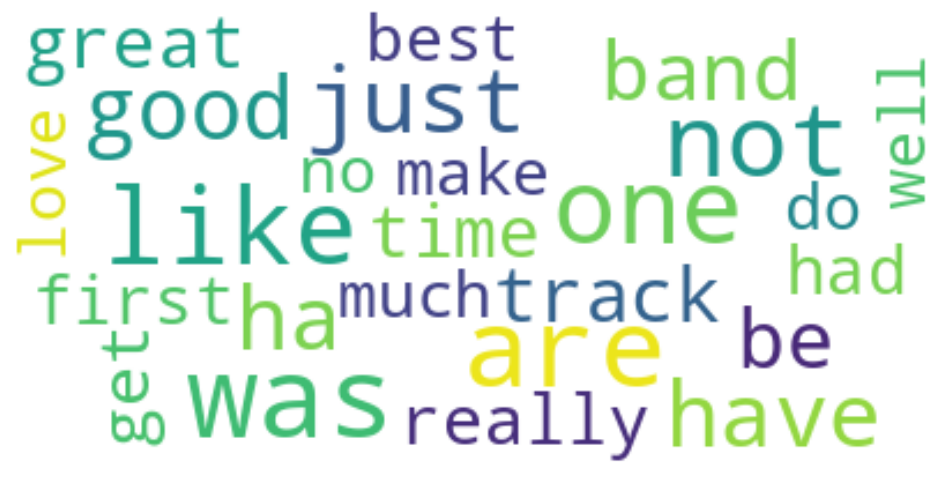

In [32]:
plot_word_cloud(negative_text, title="Negative Sentiment Word Cloud")

It doesn't seem like there are many differences between the two groups of positive and negative reviews in terms of dominant words for each group.
Some words to eliminate that are very common between both groups would be 'album', 'song', 'CD', 'quot', 'music', 'sound'.

### Word embeddings with Word2Vec

In [33]:
!pip install gensim

In [34]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [35]:
from nltk.tokenize import word_tokenize
# Create the list of sentences for the model word2vec
sentences = df_reviews['reviewText'].apply(lambda x: word_tokenize(x.lower()))

In [36]:
from gensim.models import Word2Vec

# train model word2vec
model = Word2Vec(sentences, vector_size=100, window=5, min_count=2, workers=4, epochs=10)
# Words in vocabulary
print(f"Vocabulary: {len(model.wv.key_to_index)} words")


Vocabulary: 28525 words


In [37]:
target_words = ["track", "love", "album", "listen"]

# Diccionary of clusters
word_clusters = {}
for word in target_words:
    try:
        similar_words = model.wv.most_similar(word, topn=10)
        word_clusters[word] = [word] + [w[0] for w in similar_words]
        print(f"Word: {word} -> Similar: {similar_words}")
    except KeyError:
        print(f"¡Warning: '{word}' is not in the Vocabulary!")

Word: track -> Similar: [('song', 0.8062803149223328), ('cut', 0.7814005613327026), ('tune', 0.6661140322685242), ('verse', 0.6301180720329285), ('note', 0.5905629396438599), ('tracks', 0.579833447933197), ('tk', 0.5363043546676636), ('chorus', 0.5251803994178772), ('intro', 0.5182600021362305), ('single', 0.5164757966995239)]
Word: love -> Similar: [('loved', 0.6027497053146362), ('enjoy', 0.535231351852417), ('remember', 0.5346342325210571), ('hate', 0.5343194603919983), ('think', 0.523978590965271), ('adore', 0.5193648338317871), ('beautiful', 0.5059221982955933), ('miss', 0.49721044301986694), ('know', 0.49138060212135315), ('believe', 0.49041131138801575)]
Word: album -> Similar: [('record', 0.8604915738105774), ('cd', 0.8147373199462891), ('disc', 0.707859456539154), ('release', 0.6780403256416321), ('effort', 0.675214409828186), ('compilation', 0.6402712464332581), ('lp', 0.5693531036376953), ('collection', 0.5559494495391846), ('disk', 0.5529743432998657), ('albums', 0.55246812

In [38]:
!pip install adjustText

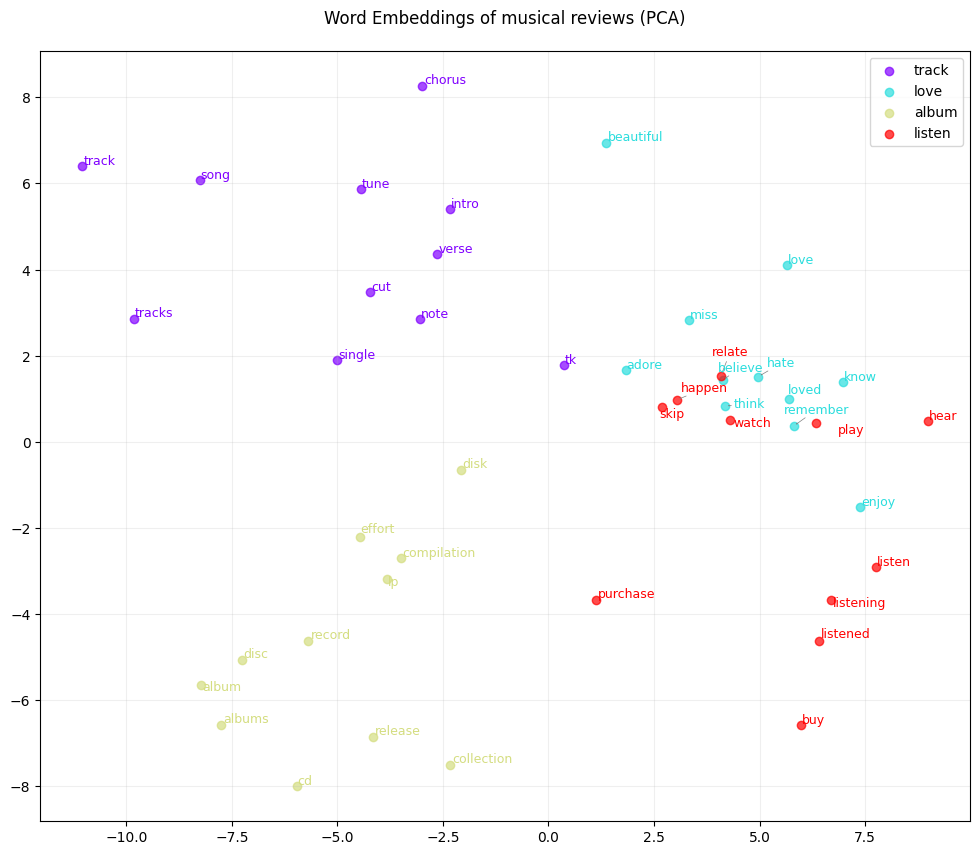

In [39]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from adjustText import adjust_text

# Collect embeddings
words = []
embeddings = []
for word, cluster in word_clusters.items():
    for w in cluster:
        words.append(w)
        embeddings.append(model.wv[w])

embeddings = np.array(embeddings)

# Reduccing with PCA
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

# Visualization
plt.figure(figsize=(12, 10))
colors = plt.cm.rainbow(np.linspace(0, 1, len(target_words)))

texts = []
for i, word in enumerate(target_words):
    start_idx = i * 11  # 10 similar + word
    end_idx = start_idx + 11
    plt.scatter(
        embeddings_2d[start_idx:end_idx, 0],
        embeddings_2d[start_idx:end_idx, 1],
        color=colors[i],
        label=word,
        alpha=0.7
    )
    # Add labels
    for j in range(start_idx, end_idx):
        texts.append(plt.text(
            embeddings_2d[j, 0],
            embeddings_2d[j, 1],
            words[j],
            fontsize=9,
            color=colors[i]
        ))

# Adjust labels
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray', lw=0.5))

plt.title("Word Embeddings of musical reviews (PCA)", pad=20)
plt.legend()
plt.grid(alpha=0.2)
plt.show()

In [40]:
unk = np.random.uniform(-np.var(model.wv.vectors), np.var(model.wv.vectors), model.wv.vector_size)

unk.shape

(100,)

### Conclusions

The dataset has many positive reviews where people loved the albums and very few negative ones. This is risky when training a model that classifies reviews because it can learn the positive reviews but do a poor job at detecting negative ones. For the training, I will try to create a more balanced train subset and then test it with a test subset that represents the reality (not selectively sampled).

32004 words without estrange punctuation, transformed numbers into words and fixing spacing issues.
I run the scripts for word cloud and n-grams for the balanced dataframe, but the conclusions and comments are the same. Not much has chaged for the balanced dataframe vs. the unbalanced.

## Preprocessing

In [41]:
#!pip install spacy


In [42]:
stopwords_custom

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'album',
 'all',
 'am',
 'an',
 'and',
 'any',
 'as',
 'at',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'cd',
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'he',
 "he'd",
 "he'll",
 "he's",
 'her',
 'here',
 "here's",
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 "how's",
 'i',
 "i'd",
 "i'll",
 "i'm",
 "i've",
 'if',
 'in',
 'into',
 'is',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 "let's",
 'me',
 'more',
 'most',
 'music',
 "mustn't",
 'my',
 'myself',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'ought',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'quot',
 'same',
 "shan't",
 'she',
 "she'd",
 "she'll",
 "she's",
 'should',
 "shouldn't",
 'so',
 'some',
 'song',
 'songs',
 'sound',
 'such',
 'than',
 'that',
 "that's",
 'the',
 'their',
 'theirs',
 'them',
 'themselves',
 'then',
 'there',
 "there's",
 'these',
 'they

In [43]:
stopwords_custom = list(stopwords_custom)

In [44]:
import spacy

# Load spaCy model (install with: python -m spacy download en_core_web_sm)
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def format_numbers(text):
    """Replace digits with their word equivalents"""
    return re.sub(r'\d+', lambda x: num2words(int(x.group())), text)

def normalize_spacing(text):
    """Fix incorrect punctuation spacing"""
    text = re.sub(r'(?<!\d)\.(?!\d|\s|$)', ' . ', text)
    text = re.sub(r'([,!?;:])(?!\s|$)', r'\1 ', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

def clean_special_chars(text, keep_apostrophes=True):
  # Remove special characters (keeping apostrophes if specified)
    pattern = r"[^\w\s']" if keep_apostrophes else r"[^\w\s]"
    text = re.sub(pattern, '', text)
    return text # Added return statement here

def preprocess_text(text, remove_stopwords=True, keep_apostrophes=True, stopwords_custom=None):
    """
    Comprehensive text preprocessing function using spaCy
    Args:
        text (str): Input text to process
        remove_stopwords (bool): Whether to remove stopwords
        keep_apostrophes (bool): Whether to preserve apostrophes in contractions
        stopwords_custom (set): Set of custom stopwords to remove
    Returns:
        list: List of processed tokens
    """
    # Initial normalization
    text = str(text).lower().strip()
    text = format_numbers(text)
    text = normalize_spacing(text)
    text = clean_special_chars(text, keep_apostrophes)


    # Process with spaCy for lemmatization and advanced tokenization
    doc = nlp(text)

    # Extract lemmas, filtering out spaces/punctuation
    # Use the global stopwords_custom set if provided, otherwise use spaCy's default
    current_stopwords = stopwords_custom if stopwords_custom is not None else nlp.Defaults.stop_words

    tokens = [
      token.lemma_.lower().strip()
      for token in doc
      if not token.is_punct
          and not token.is_space
          and (not remove_stopwords or token.lemma_.lower().strip() not in current_stopwords)
    ]

    return tokens

# Apply to DataFrame column
def preprocess_dataframe(df, text_column='reviewText'):
    """
    Process a DataFrame column with text preprocessing
    Args:
        df: Pandas DataFrame
        text_column: Name of column containing text
    Returns:
        df with a column for processed text
    """
    df_processed = df.copy()
    df_processed['processed_text'] = df_processed[text_column].apply(
    lambda text: preprocess_text(text, stopwords_custom=None))
    return df_processed

In [45]:
#df_train_balanced['processed_text'] = df_train_balanced['reviewText'].apply(preprocess_text)
processed_train = preprocess_dataframe(df_train_balanced, text_column='reviewText')
# create df_test to get it preprocess
df_test = pd.DataFrame({"reviewText": X_test, "sentiment_label": y_test})
#df_test['processed_text'] = df_test['reviewText'].apply(preprocess_text)
processed_test = preprocess_dataframe(df_test, text_column='reviewText')


In [46]:
print('Original sentence:', df_train_balanced.iloc[1]['reviewText'])
print("=== AFTER PREPROCESSING ===")
print("As tokens list:", processed_train.iloc[1]['processed_text'])
# This line caused an error in a previous turn and is commented out.
# print("\nAs joined string:", ' '.join(processed_train.iloc[0]['processed_text']))

Original sentence: In 45 years of listening to Sinatra, I'm convinced this is his finest work. He left his absolute best voice at Capitol, but this is his finest recording hour. Everything is here- great songs in exactly the right tempo, wonderful strings, and a gentle melancholia that is unique in the Sinatra canon. I've listened to this album for decades and I never tire of it.
=== AFTER PREPROCESSING ===
As tokens list: ['fortyfive', 'year', 'listen', 'sinatra', 'convince', 'fine', 'work', 'leave', 'absolute', 'good', 'voice', 'capitol', 'fine', 'recording', 'hour', 'great', 'song', 'exactly', 'right', 'tempo', 'wonderful', 'string', 'gentle', 'melancholia', 'unique', 'sinatra', 'canon', 'listen', 'album', 'decade', 'tire']


In [47]:
# Save output data for easier retrieval later on
import pickle

df_train_balanced.to_pickle('/content/drive/My Drive/Bootcamp/NLP/Project/df_train_balanced.pkl')
df_test.to_pickle('/content/drive/MyDrive/Bootcamp/NLP/Project/df_test.pkl')
df_train_orig.to_pickle('/content/drive/MyDrive/Bootcamp/NLP/Project/df_train_orig.pkl')

In [48]:
# Load data

df_train_balanced = pd.read_pickle('/content/drive/My Drive/Bootcamp/NLP/Project/df_train_balanced.pkl')
df_test = pd.read_pickle('/content/drive/MyDrive/Bootcamp/NLP/Project/df_test.pkl')

## Training of models for sentiment analysis and testing

In [49]:
X_train = processed_train['processed_text'].apply(lambda tokens: ' '.join(tokens))
y_train = processed_train['sentiment_label']
X_test = processed_test['processed_text'].apply(lambda tokens: ' '.join(tokens))
y_test = processed_test['sentiment_label']

In [50]:
print(type(X_train))
print(type(y_train))

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


In [51]:
# Codify reviews into a BoW using CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(
    max_features=5000,    # Use 5000 most frequent words
    ngram_range=(1, 3),   # uses bi-grams and tri-grams
    binary=False,          # uses frecuencies instead of binary coding
    #max_df=,
    #min_df
)

X_train_transf = vectorizer.fit_transform(X_train)  # Matriz dispersa (n_reviews x n_palabras)
X_test_cv = vectorizer.transform(X_test)

I don't use 'stop words' parameter because these where removed in the preprocessing stage.


### Simple Logistic Regression

In [52]:
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

#weights = compute_class_weight('balanced', classes=np.array([0, 1]), y=y_train)

logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train_transf, y_train) # train
y_pred_test = logistic_model.predict(X_test_cv) # test

In [53]:
print('Accuracy: ', logistic_model.score(X_train_transf, y_train))
print('Accuracy: ', logistic_model.score(X_test_cv, y_test))

Accuracy:  0.9965349965349966
Accuracy:  0.7195


I got a pretty good accuracy for this first model in the subset of training with the balanced classes situation, however, for the test subset, the accuracy of the predictions went down to 78.1%.

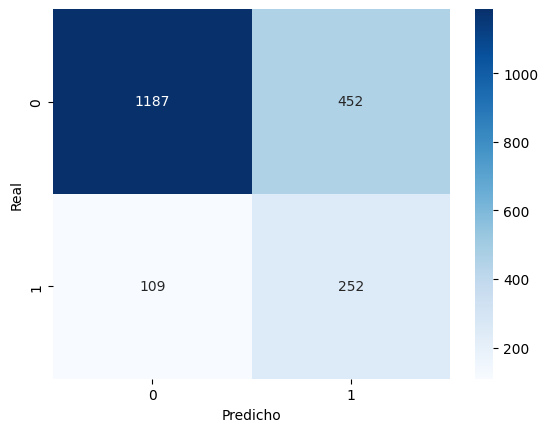

In [54]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

cm = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

This matrix represents the number of data that was predicted correctly and mislabeled by the model.
The model was able to clasify correctly 2478 of the positve reviews and 505 of the negative ones.

In [55]:
print(confusion_matrix(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test))

[[1187  452]
 [ 109  252]]
              precision    recall  f1-score   support

           0       0.92      0.72      0.81      1639
           1       0.36      0.70      0.47       361

    accuracy                           0.72      2000
   macro avg       0.64      0.71      0.64      2000
weighted avg       0.82      0.72      0.75      2000



The model correctly identifies negative reviews (`recall = 0.72`) but makes many mistakes when classifying them (`precision = 0.37`).  
In other words: when it predicts "negative," it is often wrong, but it does manage to detect a fair number of the actual negative reviews.  

**For class 0 (positive reviews):**  

- Of all the instances the model predicted as positive, **74%** were actually positive.  
- The model captured **92%** of the true positives.  
- **Good balance** between precision and recall.  

**For class 1 (negative reviews):**  
- Of all the instances the model predicted as negative, **72%** were actually negative.  
- The model only captured **37%** of the true negatives.  
- **Low performance** due to poor recall.  

In [56]:
print(confusion_matrix(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test))

[[1187  452]
 [ 109  252]]
              precision    recall  f1-score   support

           0       0.92      0.72      0.81      1639
           1       0.36      0.70      0.47       361

    accuracy                           0.72      2000
   macro avg       0.64      0.71      0.64      2000
weighted avg       0.82      0.72      0.75      2000



### Random Forest

In [57]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=200,  # Número de árboles (default=100)
    class_weight='balanced', # Manejo de clases desequilibradas
    random_state=42,
    n_jobs=-1  # Usar todos los núcleos del CPU
)
rf_model.fit(X_train_transf, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=200, n_jobs=-1,
                       random_state=42)

In [58]:
y_pred = rf_model.predict(X_test_cv)

print("Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred))

print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))

Matriz de Confusión:
[[1192  447]
 [ 101  260]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.92      0.73      0.81      1639
           1       0.37      0.72      0.49       361

    accuracy                           0.73      2000
   macro avg       0.64      0.72      0.65      2000
weighted avg       0.82      0.73      0.75      2000



In case of using a Randomforest model, the number of false negatives decreases a little and the F1-score and recall improve. But it is still conserning, the number of mislabeled negative reviews, and I wonder, if the models would learn better to clasify if I wouldn't have manually balanced the classes in the train subset, so I am going to quickly check if this is the case.

In [59]:
# I take the original datasets from the initial split between train and test subsets, and apply the tranformations to get them processed.
df_train_orig = pd.DataFrame({"reviewText": X_train_orig, "sentiment_label": y_train_orig}) # join series into one datframe

# apply processing
train_unbalanced = preprocess_dataframe(df_train_orig, text_column='reviewText')

# Create X and y
X_train_orig_proc = train_unbalanced['processed_text'].apply(lambda tokens: ' '.join(tokens))
y_train_orig_proc = train_unbalanced['sentiment_label']

# Generate BoW
X_train_unbal = vectorizer.fit_transform(X_train_orig_proc)
X_test_unbal = vectorizer.transform(X_test)

# train model with it

logistic_model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
logistic_model.fit(X_train_unbal, y_train_orig_proc) # train
y_pred_test = logistic_model.predict(X_test_unbal) # test



In [60]:
print('Accuracy: ', logistic_model.score(X_train_unbal, y_train_orig_proc))
print('Accuracy: ', logistic_model.score(X_test_unbal, y_test))

Accuracy:  0.981875
Accuracy:  0.7985


In [61]:
print("Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred_test))

print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_test))

Matriz de Confusión:
[[1411  228]
 [ 175  186]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.89      0.86      0.88      1639
           1       0.45      0.52      0.48       361

    accuracy                           0.80      2000
   macro avg       0.67      0.69      0.68      2000
weighted avg       0.81      0.80      0.80      2000



In [62]:
rf_model = RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42)
rf_model.fit(X_train_unbal, y_train_orig_proc)

y_pred_rf = rf_model.predict(X_test_unbal)
print("Random Forest Results")
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

Random Forest Results
[[1620   19]
 [ 315   46]]
              precision    recall  f1-score   support

           0       0.84      0.99      0.91      1639
           1       0.71      0.13      0.22       361

    accuracy                           0.83      2000
   macro avg       0.77      0.56      0.56      2000
weighted avg       0.81      0.83      0.78      2000




Logistic Regression (Prioritizing Recall for Negatives)
*Strengths:*
Higher recall for negative reviews (Class 1: 58%), meaning it captures more actual negatives (critical for damage control or customer service interventions).
Balanced F1-score (0.51) for negatives, outperforming Random Forest.
*Weaknesses:*
Low precision (45%) for negatives: Many false alarms (497 false positives), which could waste resources if acted upon.

*Use Case:*
Choose if missing negative reviews is costlier than investigating false positives (e.g., urgent brand reputation management).

Random Forest (Prioritizing Precision for Negatives)
*Strengths:*
High precision (80%) for negatives: When it flags a review as negative, it’s likely correct (fewer false alarms).
Near-perfect recall (99%) for positives (Class 0): Safely filters non-negative content.
*Weaknesses:*
Abysmal recall (18%) for negatives: Misses 82% of true negative reviews, a major risk for ignoring customer dissatisfaction.
*Use Case:*
Choose if minimizing false positives is paramount (e.g., automating low-priority workflows where false negatives are tolerable).


##Conclusions


*   **It is better to manage unbalanced in the data with the option available in within the models than sampling manually**
*   Removing customed stop words that included 'not', 'no', 'didn't'... didn't improve the results of the model. Only standard stop words where removed.
*   There is no perfect solution and the choice resides in the target of the problem. Wherether is minimazed the detecction of false negatives or positive reviews.

**Logistic Regression vs. Random Forest for Negative Review Detection**

In this case, after training both models with the complete train dataset with unbalanced classes and using the 'class_weight=unbalanced' option from both models, There's an improvement in the detection of negative reviews for the regresion model. Which could be the most interesting option for a company to accurately identify negative reviews and take some action on those.

**Future improvements and further exploration**

To try to improve the random forest model, we could apply GridSearch and explore what would be the best parameters to optimize its performance.

With more time available, I would have liked to explore models with Deep learning and BERT.